Importing dependencies

In [1]:
import swyft

import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
font = {"weight": "normal", "size": 12, "family": "STIXGeneral"}
axislabelfontsize = "large"
plt.rc("font", **font)
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["text.usetex"] = True

Parameters

In [2]:
# Parameters: zeta, Tvir, Rmfp, Lx, E0, \alpha
labels = [r'$\zeta$', r'$\log_{10}(T_{\rm vir}^{\rm min})$', r'$R_{\rm mfp}$',
              r'$\log_{10}(L_{\rm X})$', r'$E_0$', r'$\alpha_{\rm X}$']

# True values of the parameters
vtrue = np.array([30, 4.69897, 15, 40.5, 0.5, 1])

# Priors
vmin = np.array([10, 4.2, 8, 39.5, 100, -0.5])
vmax = np.array([100, 5.4, 25, 41.5, 900, 2.5])

# Colormap
cmap = sns.cubehelix_palette(start=0, light=0.98, dark=0.5, as_cmap=True)
cmap_2 = sns.cubehelix_palette(start=0, light=0.98, dark=0.4, as_cmap=False)
col = sns.cubehelix_palette(5)[3]

File containing log-ratio samples

In [3]:
file = open("./../Inference/01_output/logRatioSamples.pkl", "rb")
predictions = pickle.load(file)
file.close()

Rescale $E_0$ from eV to keV

In [4]:
index_y = [3, 7, 10, 12]
for i in index_y:
    predictions[1].params[:, i, 1] = predictions[1].params[:, i, 1]/1000.
    
predictions[0].params[:, 4, 0] = predictions[0].params[:, 4, 0]/1000.
predictions[1].params[:, 14, 0] = predictions[1].params[:, 14, 0]/1000.

Corner plot routine

In [5]:
def corner(
    logratios,
    parnames,
    bins=100,
    truth=None,
    figsize=(7, 7),
    color="k",
    labels=None,
    label_args={},
    contours_1d: bool = True,
    fig=None,
    labeler=None,
    smooth=0.0,
    cmap="gray_r"
) -> None:
    """Make a beautiful corner plot.
    Args:
        samples: Samples from `swyft.Posteriors.sample`
        pois: List of parameters of interest
        truth: Ground truth vector
        bins: Number of bins used for histograms.
        figsize: Size of figure
        color: Color
        labels: Custom labels (default is parameter names)
        label_args: Custom label arguments
        contours_1d: Plot 1-dim contours
        fig: Figure instance
    """
    K = len(parnames)
    if fig is None:
        fig, axes = plt.subplots(K, K, figsize=figsize)
    else:
        axes = np.array(fig.get_axes()).reshape((K, K))
    lb = 0.125
    tr = 0.9
    whspace = 0.1
    fig.subplots_adjust(
        left=lb, bottom=lb, right=tr, top=tr, wspace=whspace, hspace=whspace
    )

    diagnostics = {}

    if labeler is not None:
        labels = [labeler.get(k, k) for k in parnames]
    else:
        labels = labels
        
    for i in range(len(labels)):
        axes[i, 0].get_yaxis().set_label_coords(-0.38, 0.5)
        axes[i, 0].set_xticks([30, 60, 90])
        axes[i, 2].set_xticks([10, 15, 20])
        axes[i, 4].set_xticks([0.2, 0.5, 0.8])
        axes[i, 5].set_xticks([0, 1, 2])
        axes[2, i].set_yticks([10, 15, 20])
        axes[4, i].set_yticks([0.2, 0.5, 0.8])
        axes[5, i].set_yticks([0, 1, 2])
        
    axes[0, 0].set_ylabel("")
    axes[0, 0].set_yticks([])
    
    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            ax.tick_params(axis='both', which='major', labelsize=10, length=4)
            ax.minorticks_on()
            ax.tick_params(axis='both', which='minor', labelsize=8, length=2)
            # Switch off upper left triangle
            if i < j:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(False)
                continue

            # Formatting labels
            if j > 0 or i == 0:
                ax.set_yticklabels([])
                # ax.set_yticks([])
            if i < K - 1:
                ax.set_xticklabels([])
                # ax.set_xticks([])
            if i == K - 1:
                ax.set_xlabel(labels[j], **label_args)
            if j == 0 and i > 0:
                ax.set_ylabel(labels[i], **label_args)

            # 2-dim plots
            if j < i:
                try:
                    ax.plot((vtrue[j]), (vtrue[i]), "s", color="k", markersize=1.3)
                    ax.axvline(vtrue[j], c='k', lw=0.7, ls="--")
                    ax.axhline(vtrue[i], c='k', lw=0.7, ls="--")
                    ret = plot_2d(
                        logratios,
                        parnames[j],
                        parnames[i],
                        ax=ax,
                        color=color,
                        bins=bins,
                        smooth=smooth,
                        cmap=cmap
                    )
                except swyft.SwyftParameterError:
                    pass
            if j == i:
                try:
                    ax.axvline(vtrue[j], c='k', lw=0.7, ls="--")
                    ax.set_yticks([])
                    ret = plot_1d(
                        logratios,
                        parnames[i],
                        ax=ax,
                        color=color,
                        bins=bins,
                        contours=contours_1d,
                        smooth=smooth,
                    )
                except swyft.SwyftParameterError:
                    pass
    return fig


def get_HDI_thresholds(x, cred_level=[0.68268, 0.95450, 0.99730]):
    x = x.flatten()
    x = np.sort(x)[::-1]  # Sort backwards
    total_mass = x.sum()
    enclosed_mass = np.cumsum(x)
    idx = [np.argmax(enclosed_mass >= total_mass * f) for f in cred_level]
    levels = np.array(x[idx])
    return levels


def plot_2d(
    logratios,
    parname1,
    parname2,
    ax=plt,
    bins=100,
    color="k",
    cmap="gray_r",
    smooth=0.0,
):
    """Plot 2-dimensional posteriors."""
    counts, xy = swyft.lightning.utils.get_pdf(
        logratios, [parname1, parname2], bins=bins, smooth=smooth
    )
    xbins = xy[:, 0]
    ybins = xy[:, 1]

    levels = sorted(get_HDI_thresholds(counts))
    ax.contourf(
        counts.T,
        extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()],
        levels=levels,
        # linestyles=[":", "--", "-"],
        # colors=color,
        cmap=cmap,
        extend="max"
    )
    ax.set_xlim([xbins.min(), xbins.max()])
    ax.set_ylim([ybins.min(), ybins.max()])


def plot_1d(
    logratios,
    parname,
    weights_key=None,
    ax=plt,
    grid_interpolate=False,
    bins=100,
    color=cmap(0.99),
    contours=True,
    smooth=0.0,
):
    """Plot 1-dimensional posteriors."""
    v, zm = swyft.lightning.utils.get_pdf(logratios, parname, bins=bins, smooth=smooth)
    zm = zm[:, 0]
    levels = sorted(get_HDI_thresholds(v))
    # print(levels)
    if contours:
        contour1d(zm, v, levels, ax=ax, color=color)
    ax.plot(zm, v, color=color, lw=1)
    ax.set_xlim([zm.min(), zm.max()])
    ax.set_ylim([-v.max() * 0.05, v.max() * 1.1])


def contour1d(z, v, levels, ax=plt, linestyles=None, color=None, **kwargs):
    y0 = -1.0 * v.max()
    y1 = 5.0 * v.max()
    ax.fill_between(z, y0, y1, where=v > levels[0], color=cmap_2[1], alpha=0.3)
    ax.fill_between(z, y0, y1, where=v > levels[1], color=cmap_2[2], alpha=0.4)
    ax.fill_between(z, y0, y1, where=v > levels[2], color=cmap_2[4], alpha=0.5)

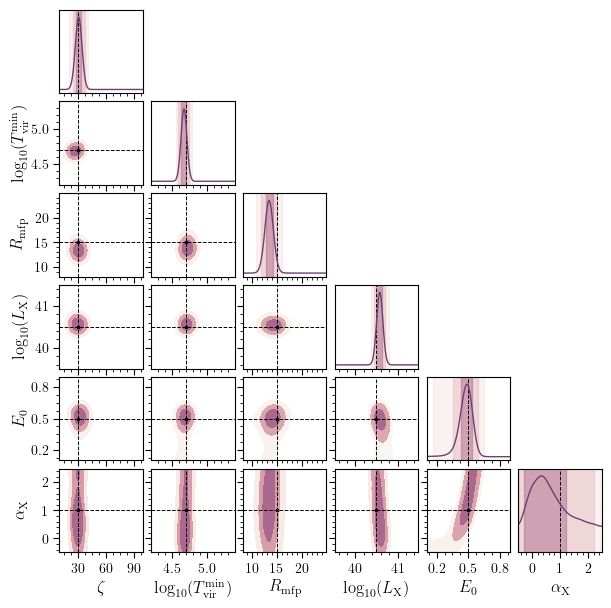

In [6]:
corner(predictions, ("z[0]", "z[1]", "z[2]", "z[3]", "z[4]", "z[5]"), smooth=3,
       labels=labels, color=col, cmap=cmap);
plt.savefig("./plots/01_post.pdf", bbox_inches="tight")